In [104]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
from tqdm.notebook import tqdm 
import h5py
#%matplotlib widget

In [105]:
datapath ="./dane vibstand/"
filelist = os.listdir(datapath)
print(sorted(filelist))
filenames  =sorted(filelist)
df_list = []
for filename in sorted(filelist):
    f = h5py.File(datapath +filename,'r')
    data_names = np.array(f.get('/'))
    dictionary = {}
    for i in range(0,len(data_names)-1):
        name = data_names[i]
        dictionary.update({name : np.array(f.get('/'+name)).T[0]})
    df = pd.DataFrame.from_dict(dictionary)
    df_list.append(df)

['speed_10.mat', 'speed_15.mat', 'speed_20.mat', 'speed_25_5.mat']


In [106]:
df_list[0]

,Vib1,Vib2,Vib3,Vib4
0,0.114942,0.054475,0.109383,0.038406
1,0.134302,0.070976,0.067187,0.060843
2,0.109095,0.080916,0.085132,0.095247
3,0.080835,0.074809,0.146377,0.061429
4,0.057967,0.107356,0.118420,0.044259
...,...,...,...,...
1974995,0.134172,0.178168,-0.047827,0.081720
1974996,0.125597,0.177389,-0.039440,0.118661
1974997,0.101754,0.172971,-0.022925,0.108970
1974998,0.138655,0.153352,-0.037229,0.129847


In [107]:
def create_signal(alpha, impulse_amplitude, seed, speed):
    fs = 500000/speed
    fmod = 30
    f_center = 5000
    bandwidth = 1500
    shift = 0

    amp_imp = impulse_amplitude
    alfa = alpha
    skala = 1

    varsize = 1975000#1*fs
    tt_ts = np.linspace(1/fs,varsize/fs,varsize)
    #szum = np.random.normal(0,skala,varsize) #szum Gaussowski

    szum = levy_stable.rvs(alfa,0,0,skala,varsize, random_state=seed)  #szum alfa-stabilny

    signal_l = 2*impsim(fs,varsize,fmod,amp_imp,f_center,bandwidth,shift)+szum
    return signal_l

In [112]:
speeds = [10,15,20,25]
df_list = []

for i in range(0,4):
    speed = speeds[i]
    dictionary = {}
    for j in range(0,4):
        #Vib1=horizontal bad etc
        alpha = 1.98+0.02*((j%2)-0.5)
        impulse_amplitude = 10*(j//2) 
        print(i,j,alpha, impulse_amplitude, speed)
        signal = create_signal(alpha, impulse_amplitude, 4*i+j, speed)
        
        if j <2:
            signal = signal / 5
        elif j>=2:
            signal = signal / 50
        dictionary.update({"Vib{}".format(j+1):signal})
    df = pd.DataFrame.from_dict(dictionary)
    df_list.append(df)

0 0 1.97 0 10
0 1 1.99 0 10
0 2 1.97 10 10
0 3 1.99 10 10
1 0 1.97 0 15
1 1 1.99 0 15
1 2 1.97 10 15
1 3 1.99 10 15
2 0 1.97 0 20
2 1 1.99 0 20
2 2 1.97 10 20
2 3 1.99 10 20
3 0 1.97 0 25
3 1 1.99 0 25
3 2 1.97 10 25
3 3 1.99 10 25


In [113]:
df_list[0]

,Vib1,Vib2,Vib3,Vib4
0,0.045692,-0.013669,-0.009130,0.005801
1,0.328873,0.056856,-0.076066,0.032422
2,0.055051,-0.973052,0.008775,-0.037565
3,0.023816,-0.229873,-0.001889,0.003041
4,-0.081603,-0.253115,-0.007552,0.011635
...,...,...,...,...
1974995,-0.146540,0.437143,-0.017898,0.044972
1974996,-0.235660,-0.086661,0.041449,-0.032912
1974997,0.487498,-0.062394,0.006570,0.002655
1974998,-0.143205,0.050592,0.031100,0.046294


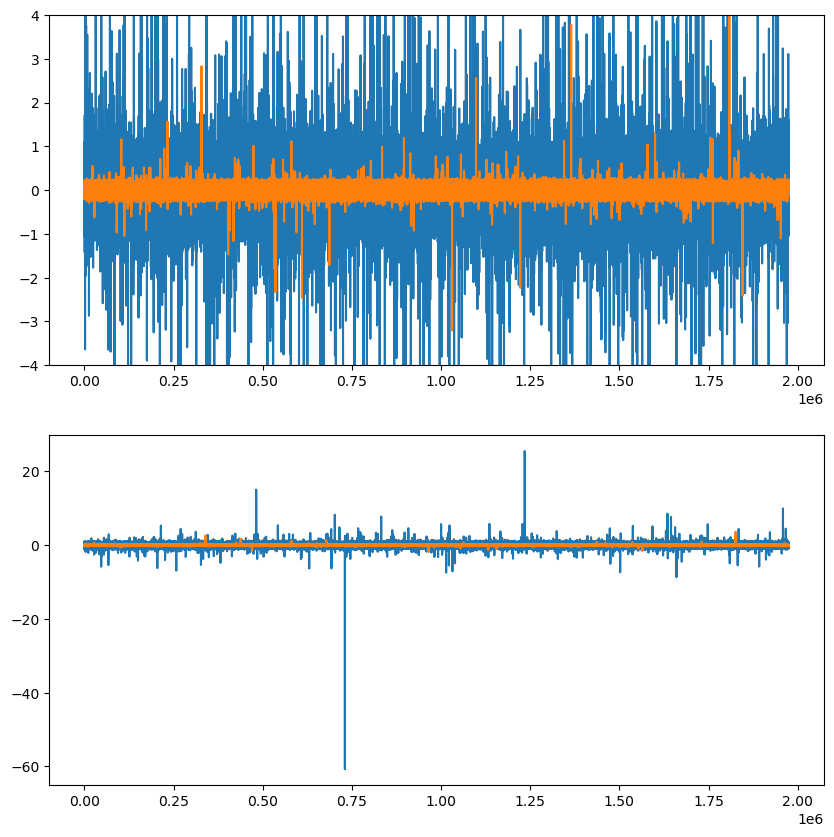

In [115]:
df = df_list[0]
f,ax = plt.subplots(2,1, figsize =(10,10))
ax[0].plot(df["Vib1"])
ax[0].plot(df["Vib3"])
ax[0].set_ylim((-4,4))
ax[1].plot(df["Vib2"])
ax[1].plot(df["Vib4"])
plt.show()

In [64]:
speed = 10
cyclic_impulses = create_signal(1.8,9, 0, speed)-create_signal(1.8,0, 0, speed)
np.arange(len(cyclic_impulses))[cyclic_impulses>0.4][:50]

array([  18,   31,   32,   33,   34,   40,   41,   42,   43,   44,   51,
         52,   53,   54,   61,   62,   63,   64,   71,   72,   73,   74,
         81,   82,   83,   84,   91,   92,   93,   94,  102, 1685, 1698,
       1699, 1700, 1701, 1707, 1708, 1709, 1710, 1711, 1718, 1719, 1720,
       1721, 1728, 1729, 1730, 1731, 1738])

In [116]:
def compute_diagram(data, dim, delay, skip, normalize = True, weighted = True, point_cloud_size = 100):
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform([data])[0]
    if len(point_clouds>250):
        skip = max(len(point_clouds)//250,1)
        tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
        point_clouds = tde.transform([data])[0] 
    #point_clouds = levy_stable.rvs(alpha,0,0, size=(100,2))

    if (normalize):
        point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
        point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]

    pc = point_clouds
    #print(len(pc))

    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(points=pc)
    
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    return pd

In [117]:
n_samples = 10
norms = np.zeros((4,4,n_samples))
start = 2.98
end = 3.7
grid = np.linspace(start,end,1000)
bc = BettiCurve(predefined_grid=grid)
betti_curves = np.zeros((4,4,n_samples,1000))

speeds = [10,15,20,25]


for j in tqdm(range(0,len(df_list))):
    scaling_factor =(j+2)*0.5    
    dim = int(2.25*810*(1/(scaling_factor)))
    delay = int(36*scaling_factor)
    
    print("Speed {}, dim = {}, delay = {}".format(speeds[j],dim,delay))
    
    skip =1
    for i in range(0,4):
        samples = np.array_split(df_list[j].iloc[:,i].values,n_samples)
        
        for k in range(0,len(samples)):
            diagram = compute_diagram(samples[k], dim, delay, skip, point_cloud_size = 250)
            #bc = np.array(compute_bc_from_ts(samples[k], dim, delay, skip))
            curve = np.array(bc.fit_transform([diagram])[0])
            betti_curves[j,i,k] = curve
            #norm = compute_norms_from_ts(samples[k], dim, delay, skip)
            norm = wasserstein_distance(diagram,[], order=1, internal_p = 1)
            
            norms[j,i,k] = norm

  0%|          | 0/4 [00:00<?, ?it/s]

Speed 10, dim = 1822, delay = 36
Speed 15, dim = 1215, delay = 54
Speed 20, dim = 911, delay = 72
Speed 25, dim = 729, delay = 90


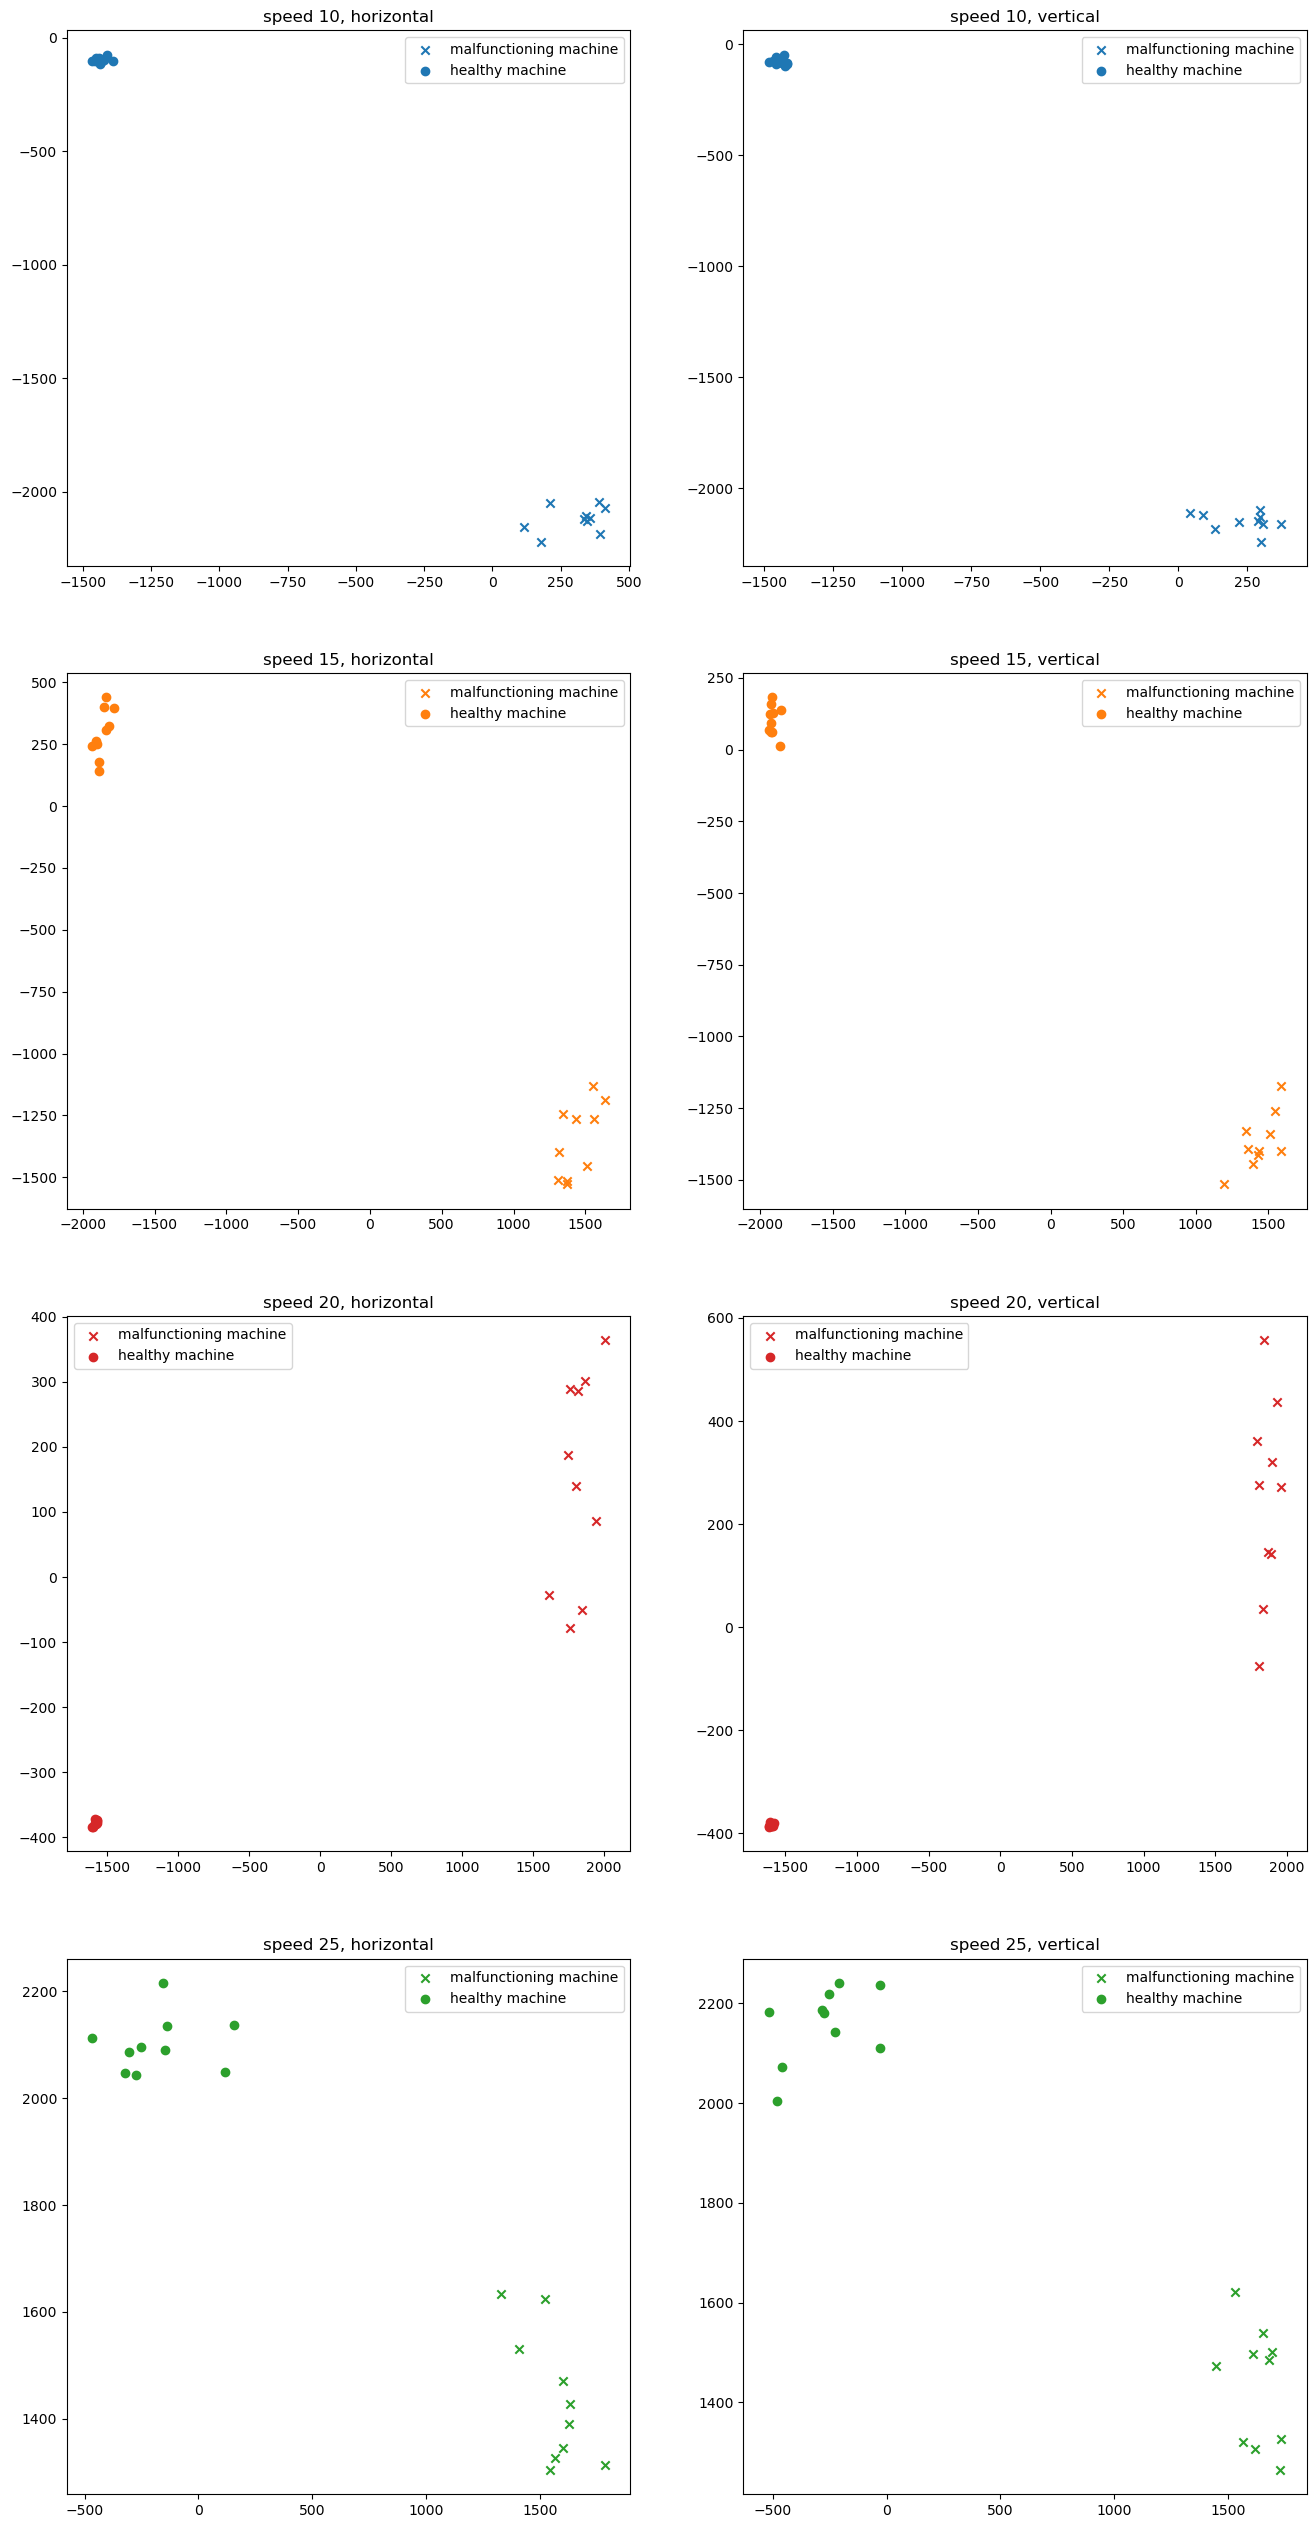

[0.431241   0.35057436 0.09891134]


In [118]:
pca = PCA(n_components=3)
pca.fit_transform([betti_curves[j,i,k] for j in range(0,4) for i in range(0,4) for k in range(0,n_samples)])

fig,ax = plt.subplots(4,2,figsize=(16,32))
#ax.scatter(emb[:,0],emb[:,1])#,  marker = "o", c=t, label="malfunctioning machine {}".format(i))
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    emb_bad_h = pca.transform(betti_curves[i,0,:])
    emb_good_h = pca.transform(betti_curves[i,2,:])
    ax[i,0].scatter(emb_bad_h[:,0],emb_bad_h[:,1], marker = "x", c=colors[i], label="malfunctioning machine")
    ax[i,0].scatter(emb_good_h[:,0],emb_good_h[:,1], marker = "o", c=colors[i], label="healthy machine")
    ax[i,0].set_title("speed {}, horizontal".format(speeds[i]))
    ax[i,0].legend()
    emb_bad_v = pca.transform(betti_curves[i,1,:])
    emb_good_v = pca.transform(betti_curves[i,3,:])
    ax[i,1].scatter(emb_bad_v[:,0],emb_bad_v[:,1], marker = "x", c=colors[i], label="malfunctioning machine")
    ax[i,1].scatter(emb_good_v[:,0],emb_good_v[:,1], marker = "o", c=colors[i], label="healthy machine")
    ax[i,1].set_title("speed {}, vertical".format(speeds[i]))
    ax[i,1].legend()


plt.show()
print(pca.explained_variance_ratio_)

speed 10, horizontal: malfunctioning avg l2 norm = 10.470511702279037, std = 0.22482709558395808
speed 10, horizontal: helathy avg l2 norm = 6.959728822521828, std = 0.8009612663768138
speed 10, vertical: malfunctioning avg l2 norm = 10.431838085651098, std = 0.23203906432361107
speed 10, vertical: helathy avg l2 norm = 7.249485080524624, std = 0.8801434247274164
speed 15, horizontal: malfunctioning avg l2 norm = 12.583758533628345, std = 0.3813814472557371
speed 15, horizontal: helathy avg l2 norm = 10.42164329776482, std = 0.46287379476589013
speed 15, vertical: malfunctioning avg l2 norm = 12.54161407775188, std = 0.34311547351258037
speed 15, vertical: helathy avg l2 norm = 10.36974567682289, std = 0.46165554020235444
speed 20, horizontal: malfunctioning avg l2 norm = 14.039787560812368, std = 0.5486907985965619
speed 20, horizontal: helathy avg l2 norm = 2.426845867860877, std = 1.2913981396365282
speed 20, vertical: malfunctioning avg l2 norm = 14.30999052261969, std = 0.39458250

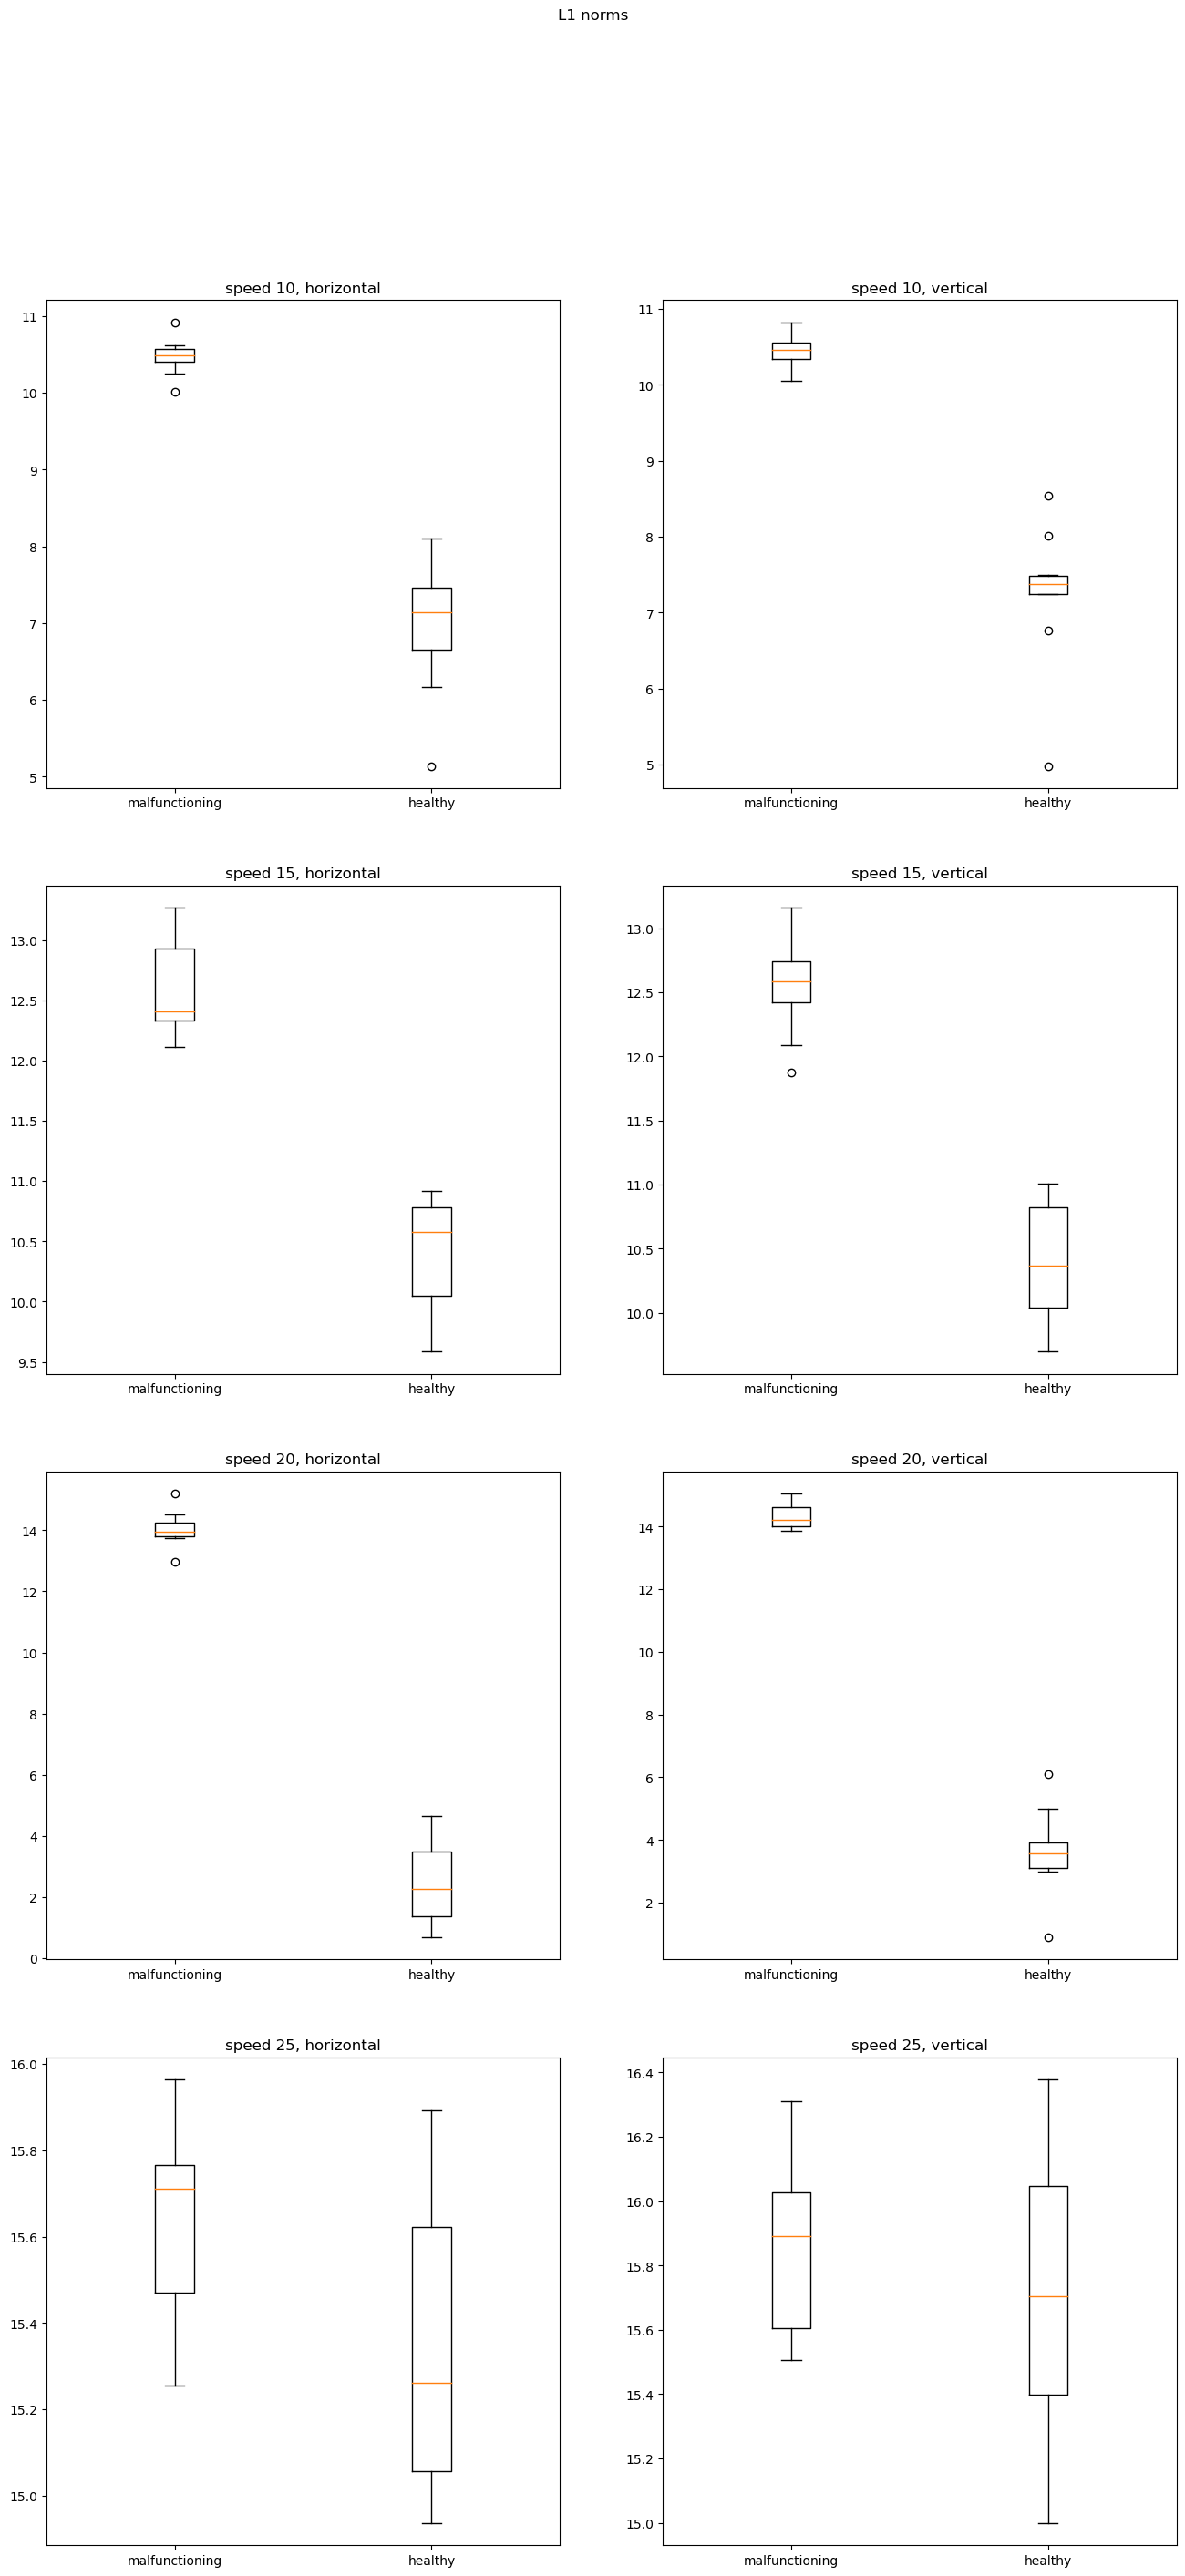

In [119]:
fig,ax = plt.subplots(4,2,figsize=(16,32))

##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    ax[i,0].boxplot([norms[i,0,:],norms[i,2,:]])
    ax[i,0].set_title("speed {}, horizontal".format(speeds[i]))
    ax[i,0].set_xticklabels(["malfunctioning", "healthy"])
    
    ax[i,1].boxplot([norms[i,1,:],norms[i,3,:]])
    ax[i,1].set_title("speed {}, vertical".format(speeds[i]))
    ax[i,1].set_xticklabels(["malfunctioning", "healthy"])

    print("speed {}, horizontal: malfunctioning avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,0,:]), np.std(norms[i,0,:]) ))
    print("speed {}, horizontal: helathy avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,2,:]), np.std(norms[i,2,:]) ))
    print("speed {}, vertical: malfunctioning avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,1,:]), np.std(norms[i,1,:]) ))
    print("speed {}, vertical: helathy avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,3,:]), np.std(norms[i,3,:]) ))
          
          
fig.suptitle("L1 norms")
plt.show()

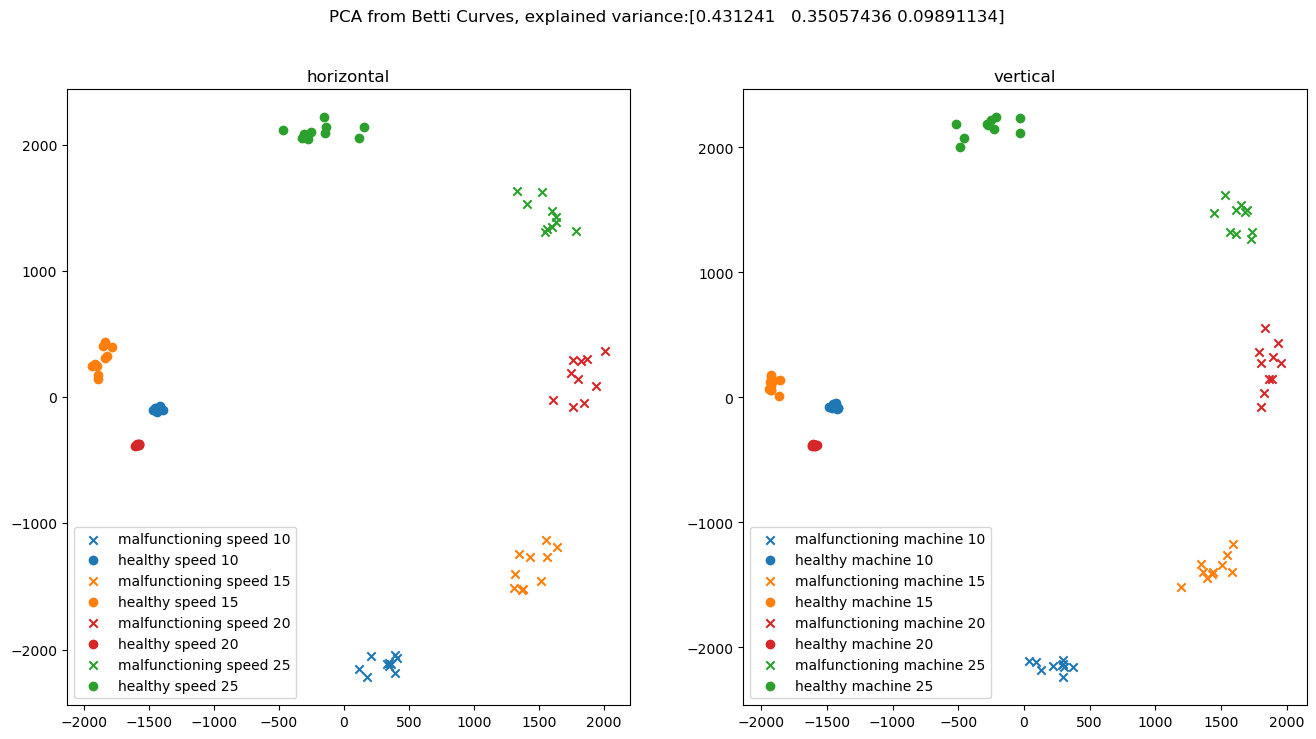

In [120]:
pca = PCA(n_components=3)
pca.fit_transform([betti_curves[j,i,k] for j in range(0,4) for i in range(0,4) for k in range(0,n_samples)])

fig,ax = plt.subplots(1,2,figsize=(16,8))
#ax.scatter(emb[:,0],emb[:,1])#,  marker = "o", c=t, label="malfunctioning machine {}".format(i))
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    emb_bad_h = pca.transform(betti_curves[i,0,:])
    emb_good_h = pca.transform(betti_curves[i,2,:])
    ax[0].scatter(emb_bad_h[:,0],emb_bad_h[:,1], marker = "x", c=colors[i], label="malfunctioning speed {}".format(speeds[i]))
    ax[0].scatter(emb_good_h[:,0],emb_good_h[:,1], marker = "o", c=colors[i], label="healthy speed {}" .format(speeds[i]))
    ax[0].set_title("horizontal")
    ax[0].legend()
    emb_bad_v = pca.transform(betti_curves[i,1,:])
    emb_good_v = pca.transform(betti_curves[i,3,:])
    ax[1].scatter(emb_bad_v[:,0],emb_bad_v[:,1], marker = "x", c=colors[i], label="malfunctioning machine {}".format(speeds[i]))
    ax[1].scatter(emb_good_v[:,0],emb_good_v[:,1], marker = "o", c=colors[i], label="healthy machine {}".format(speeds[i]))
    ax[1].set_title("vertical")
    ax[1].legend()

fig.suptitle("PCA from Betti Curves, explained variance:{}".format(pca.explained_variance_ratio_))
plt.show()
#print()